## 데이터 합치기 및 생성

In [ ]:
# %%
import os
import pandas as pd

BASE_DIR = os.path.dirname(os.path.abspath(__file__))
print("BASE_DIR:", BASE_DIR)

ANNO_DIR = os.path.join(BASE_DIR, "Anno")
EVAL_DIR = os.path.join(BASE_DIR, "Eval")

bbox_path = os.path.join(ANNO_DIR, "list_bbox_consumer2shop.txt")
item_path = os.path.join(ANNO_DIR, "list_item_consumer2shop.txt")
eval_path = os.path.join(EVAL_DIR, "list_eval_partition.txt")

print("Anno 존재:", os.path.exists(ANNO_DIR))
print("Eval 존재:", os.path.exists(EVAL_DIR))
print("bbox 존재:", os.path.exists(bbox_path))
print("item 존재:", os.path.exists(item_path))
print("eval 존재:", os.path.exists(eval_path))

out_csv = os.path.join(BASE_DIR, "out_datas.csv")
import os

base = r"D:\승연\인공지능학과\2025 인공지능\2학기\컴비\2025CV\img"

for root, dirs, files in os.walk(base):
    for f in files:
        if "comsumer" in f:   # 오타
            old = os.path.join(root, f)
            new_name = f.replace("comsumer", "consumer")
            new = os.path.join(root, new_name)
            os.rename(old, new)
            print(old, "→", new)

# %%
##########################
# 1) BBOX 읽기
##########################
cols = ['image_name','clothes_type','source_type','x1','y1','x2','y2']
df = pd.read_csv(bbox_path, sep=r"\s+", skiprows=2, names=cols)

df['image_name'] = df['image_name'].str.replace("comsumer","consumer", regex=False)

df['item_id'] = df['image_name'].str.extract(r"(id_\d+)")
df['type'] = df['source_type'].map({1:'shop', 2:'consumer'})

cons = df[df['type']=='consumer'][[
    'item_id','image_name','x1','y1','x2','y2'
]].rename(columns={
    'image_name':'consumer_path',
    'x1':'cons_x1','y1':'cons_y1','x2':'cons_x2','y2':'cons_y2'
})

shop = df[df['type']=='shop'][[
    'item_id','image_name','x1','y1','x2','y2'
]].rename(columns={
    'image_name':'shop_path',
    'x1':'shop_x1','y1':'shop_y1','x2':'shop_x2','y2':'shop_y2'
})

pairs = cons.merge(shop, on="item_id", how="inner")
# %%
##########################
# 2) eval 파일 파싱
##########################
eval_df = pd.read_csv(eval_path, sep=r"\s+", skiprows=2,
                      names=['consumer_path','shop_path','item_id','split'])

eval_df['consumer_path'] = eval_df['consumer_path'].str.replace("comsumer","consumer", regex=False)
# %%
##########################
# 3) split merge
##########################
pairs = pairs.merge(eval_df[['consumer_path','split']], on='consumer_path', how='left')
pairs['split'] = pairs['split'].fillna("train")
# %%
##########################
# 4) 저장 (bbox 포함)
##########################
pairs.to_csv(out_csv, index=False)

print("총 pair 수:", len(pairs))
print(pairs.head())

# %%
##########################
# 5) 이미지 존재 여부 확인
##########################

IMG_DIR = os.path.join(BASE_DIR, "img")  # img 폴더 경로

def exists_in_img(path):
    """consumer_path, shop_path는 상대경로라서 실제 파일경로로 변환"""
    full = os.path.join(IMG_DIR, path)
    return os.path.exists(full)

# 각 row마다 이미지 존재 체크
pairs['consumer_exists'] = pairs['consumer_path'].apply(exists_in_img)
pairs['shop_exists'] = pairs['shop_path'].apply(exists_in_img)

# 누락된 파일만 따로 추출
missing_consumer = pairs[~pairs['consumer_exists']]['consumer_path'].unique()
missing_shop = pairs[~pairs['shop_exists']]['shop_path'].unique()

print("\n❌ consumer 이미지 누락 개수:", len(missing_consumer))
print("예시:", list(missing_consumer)[:10])

print("\n❌ shop 이미지 누락 개수:", len(missing_shop))
print("예시:", list(missing_shop)[:10])

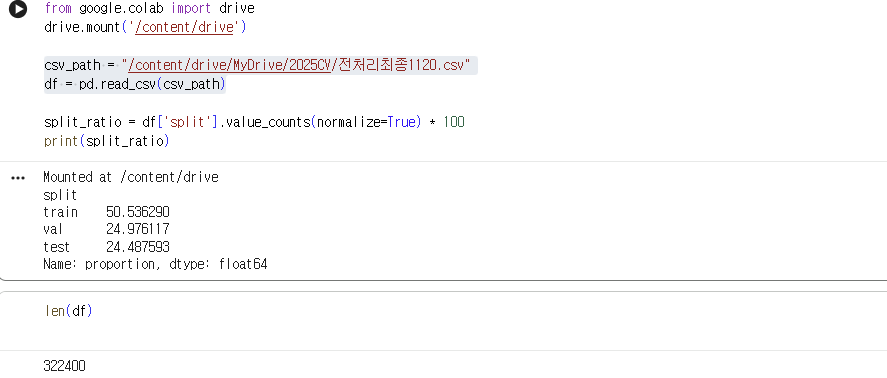

In [ ]:
# 남길 카테고리(폴더명)
keep_categories = ["DRESSES", "TOPS"]

# consumer_path 또는 shop_path에 포함된 카테고리 필터링
df_filtered = df[
    df["consumer_path"].str.contains("|".join(keep_categories))
]

# 저장
df_filtered.to_csv("out_datas_filtered.csv", index=False)

print("원본 행 개수:", len(df))
print("필터링 후 행 개수:", len(df_filtered))
print("완료! → out_datas_filtered.csv 저장됨")


## Transform 정의

In [ ]:
from torchvision import transforms

# 학습용 (데이터 증강 포함)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 검증용 (증강 없음)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


## Dataset 정의

In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class DeepFashionC2S(Dataset):
    def __init__(self, csv_path, img_root, transform=None, split="train"):
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['split'] == split].reset_index(drop=True)
        self.img_root = img_root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def load_crop(self, img_path, x1, y1, x2, y2):
        full = Image.open(os.path.join(self.img_root, img_path)).convert("RGB")
        crop = full.crop((x1, y1, x2, y2))
        return crop

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # consumer 이미지 crop
        cons_img = self.load_crop(
            row['consumer_path'],
            row['cons_x1'], row['cons_y1'], row['cons_x2'], row['cons_y2']
        )

        # shop 이미지 crop
        shop_img = self.load_crop(
            row['shop_path'],
            row['shop_x1'], row['shop_y1'], row['shop_x2'], row['shop_y2']
        )

        if self.transform:
            cons_img = self.transform(cons_img)
            shop_img = self.transform(shop_img)

        return {
            "consumer": cons_img,
            "shop": shop_img,
            "item_id": row["item_id"]
        }


## Dataloader 정의

In [ ]:
from torch.utils.data import DataLoader

CSV_PATH = "/content/drive/MyDrive/2025CV/전처리최종1120.csv"
IMG_DIR = "/content/drive/MyDrive/2025CV/Img"

train_ds = DeepFashionC2S(CSV_PATH, IMG_DIR, transform=train_transform, split="train")
val_ds   = DeepFashionC2S(CSV_PATH, IMG_DIR, transform=val_transform, split="val")

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_dl   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4)
